In [1]:
from sklearn.decomposition import PCA

In [26]:
import numpy as np 
import open3d as o3d
import os
from natsort import natsorted
from glob import glob
from upsampling_mesh import meshify
from sklearn.neighbors import NearestNeighbors
import ckwrap 
import matplotlib.pyplot as plt
from scipy.io import savemat

o3d.utility.set_verbosity_level(o3d.utility.VerbosityLevel.Error)

def find_neighs(points, k=2):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm= 'kd_tree').fit(points)
    distances, indices = nbrs.kneighbors(points) 
    return distances, indices

def fit_plane(points):
    # print(points.shape)
    dists_ori, indices_ori = find_neighs(points, k=250)
    pcd_neighs = points[indices_ori]
    # print(pcd_neighs.shape)
    norms_arr= []
    for pt in pcd_neighs:
        pca = PCA(n_components=3)
        pca.fit(pt)
        norms_arr.append(pca.components_[2])
    # print("norms_arr shape: ", np.array(norms_arr).shape)
    return norms_arr

def patching(points, normals, radius_chosen):
    dists_ori, indices_ori = find_neighs(points, k=250)
    dists_ori = dists_ori[:, 1:]
    indices_ori = indices_ori[:, 1:]
    
    # Apply ckmeans to all rows and extract labels using a lambda function:
    labels_per_row = np.apply_along_axis(lambda row: ckwrap.ckmeans(row, 5).labels, 1, dists_ori)

    # print("labels_arr shape: ",labels_per_row.shape)  # Now displays the actual labels for each row

    '''
    dists_array has 5 lists within, each list represents a cluster and has 2048 elements.
    '''
    dists_arrays = [[] for _ in np.unique(labels_per_row[0])]
    indices_arrays = [[]for _ in np.unique(labels_per_row[0])]
    for dist, ind, labels in zip(dists_ori, indices_ori, labels_per_row):
        # dist, ind, labels of shapes: (19,)
        for i in  np.unique(labels):
            temp_i = ind[np.where(labels == i)[0]]
            temp_d = dist[np.where(labels == i)[0]]
            dists_arrays[i].append(np.array([temp_d], dtype=object))
            indices_arrays[i].append(np.array([temp_i], dtype=object))
    return dists_arrays, indices_arrays


def visualize_clustered_points(dists_arrays):
    #visualising the clusters

    fig, ax = plt.subplots() 
    colors = ['blue', 'red', 'green', 'purple', 'orange']  
    for i, bucket in enumerate(dists_arrays):
        ax.plot(bucket[0], [i] * len(bucket[0]), '.', color=colors[i], markersize=10)

    plt.xlabel("Data Values")
    plt.ylabel("Cluster Labels")
    plt.title("Clustered Data")
    plt.grid(True)
    plt.show()


In [ ]:

pcd_list = np.load('pcd_list.npy')
norm_list = np.load('normals_list.npy')
dists_array, indices_array = patching(pcd_list[10], norm_list[10], 0.1)
print(dists_array, indices_array, " done")
    


In [7]:
# len(dists_array[2]), len(norms_array[2])
# dists_array[2][0].shape, norms_array[2][0].shape

(1, 2048)

In [4]:
def fit_plane(points):
    # print(points.shape)
    pca = PCA(n_components=3)
    pca.fit(points)
    normal = pca.components_[2]
    return normal

In [125]:
dists_ori, indices_ori = find_neighs(pcd_list[10], k=250)

In [126]:
pcd =pcd_list[10]

In [36]:
# dists_ori = dists_ori[:, 1:]
# indices_ori = indices_ori[:, 1:]

In [127]:
pcd_neighs = pcd[indices_ori]

In [8]:
pcd_neighs.shape

(2048, 250, 3)

In [ ]:
norms_per_patch = np.apply_along_axis(fit_plane, 1, pcd_neighs)

In [12]:
norms_arr= []
for pt in pcd_neighs:
    norm = fit_plane(pt)
    norms_arr.append(norm)
    break

(250, 3)
(250, 250, 3)
norms_arr shape:  (250, 3)


In [10]:
norms_arr =np.asarray(norms_arr)
norms_arr.shape

(2048, 3)

In [84]:
norms_arr

array([[-0.0185272 ,  0.9823477 , -0.18614438],
       [-0.71165878,  0.6956156 , -0.0982889 ],
       [ 0.30751547,  0.9281334 , -0.20976804],
       ...,
       [-0.22964965,  0.96999881, -0.07977062],
       [ 0.25025212,  0.96633213, -0.05980048],
       [ 0.36594333, -0.90351374,  0.22304351]])

In [27]:
all_norms = []
for pcd in pcd_list:
    ans= fit_plane(pcd)
    # ans=np.asarray(ans)
    all_norms.append(ans)
    

print(len(all_norms))
all_norms = np.array(all_norms)
print(all_norms.dtype)
np.save('normals_list_f.npy', all_norms)

16867
float64


In [24]:
all_norms[0].shape

(2048, 3)

In [103]:
x = np.load('normals_list_f.npy')

y = np.load('normals_list2.npy')
print(x.shape==y.shape)

True


In [102]:
import torch
import gc
def print_gpu_tensors():
    tensor_names = [name for name, var in globals().items() if torch.is_tensor(var) and var.device.type == 'cuda']
    for name in tensor_names:
        var = globals()[name]
        print(f"{name}: {var.shape}, dtype={var.dtype}, device={var.device}")
        del globals()[name]
        gc.collect()
        torch.cuda.empty_cache()

# Create some tensors on the GPU
# x = torch.randn(1000, 1000).to('cuda')
# y = torch.randn(1000, 1000).to('cuda')

# Call the function to print GPU tensors and delete them
print_gpu_tensors()

# Check the current GPU memory usage in bytes
current_memory_before = torch.cuda.memory_allocated()
current_memory = torch.cuda.memory_allocated()

# Check the peak GPU memory usage in bytes
peak_memory = torch.cuda.max_memory_allocated()

print(f"Current GPU memory usage: {current_memory / 1024 / 1024:.2f} MB")
print(f"Peak GPU memory usage: {peak_memory / 1024 / 1024:.2f} MB")


Current GPU memory usage: 9614.06 MB
Peak GPU memory usage: 11181.28 MB


In [104]:
import torch
x = torch.from_numpy(x[:300]).to('cuda')
y = torch.from_numpy(y[:300]).to('cuda')
y = torch.transpose(y, 2, 1)
comp = torch.matmul(x, y)

OutOfMemoryError: CUDA out of memory. Tried to allocate 9.38 GiB (GPU 0; 11.92 GiB total capacity; 9.42 GiB already allocated; 1.86 GiB free; 9.42 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [66]:
torch.diagonal(comp, dim1=1, dim2=2).mean()

tensor(-0.0004, device='cuda:0', dtype=torch.float64)

In [47]:
torch.cuda.device_count()

2

In [101]:
import torch

# Example 2D tensors
tensor1 = torch.tensor([[1, 2, 3], [4, 5, 6]])
tensor2 = torch.tensor([[1, 2, 3], [10, 11, 12]])

# Compute dot product of corresponding elements along axis 1
dot_product = (tensor1 * tensor2).sum(dim=1)

print("Dot product along axis 1:", dot_product)


Dot product along axis 1: tensor([ 14, 167])


In [99]:
torch.matmul(torch.tensor([1, 2, 3]), torch.tensor([7, 8, 9]))

tensor(50)

In [100]:
tensor1 * tensor2


tensor([[ 7, 16, 27],
        [40, 55, 72]])

In [138]:
import open3d as o3d

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(chk_pcd[10])
# pcd.normals = o3d.utility.Vector3dVector((y[10].T.cpu().numpy()))
# o3d.visualization.draw_geometries([pcd], point_show_normal=True)
o3d.visualization.draw_geometries([pcd])


In [142]:
import open3d as o3d

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pcd_list[5000])
# pcd.normals = o3d.utility.Vector3dVector((y[10].T.cpu().numpy()))
# o3d.visualization.draw_geometries([pcd], point_show_normal=True)
o3d.visualization.draw_geometries([pcd])


(2048, 250, 3)


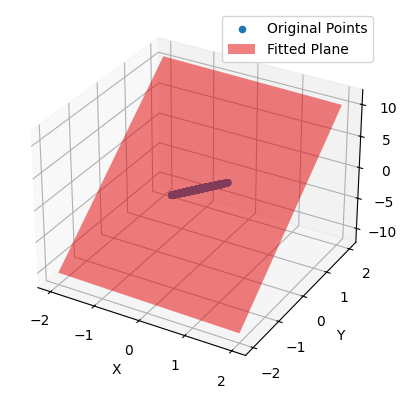

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def fit_plane(points):
    pca = PCA(n_components=3)
    pca.fit(points)
    normal = pca.components_[2]
    return normal

dists_ori, indices_ori = find_neighs(pcd_list[10], k=250)
chk_pcd = pcd_list[10][indices_ori]
print(chk_pcd.shape) # 2048, 250, 3

# Fit the plane
plane_normal = fit_plane(chk_pcd[0])

# Create a meshgrid for the plane
xx, yy = np.meshgrid(np.linspace(-2, 2, 2), np.linspace(-2, 2, 2))
zz = (-plane_normal[0] * xx - plane_normal[1] * yy) / plane_normal[2]

# Plot the points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(chk_pcd[:, 0], chk_pcd[:, 1], chk_pcd[:, 2], marker='o', label='Original Points')

# Plot the fitted plane
ax.plot_surface(xx, yy, zz, alpha=0.5, color='red', label='Fitted Plane')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

plt.show()


In [135]:
chk_pcd[0].shape

(250, 3)

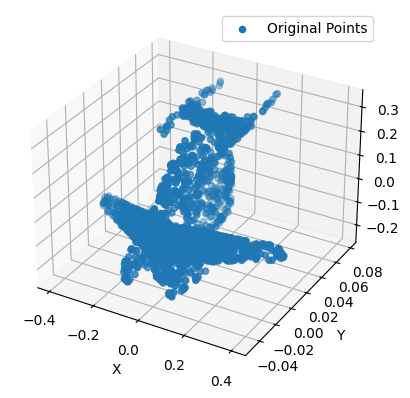

In [133]:
#scatter plot
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(chk_pcd[0][:,0], chk_pcd[:, 1], chk_pcd[:, 2], marker='o', label='Original Points')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()
